[  5.33752441e-02   4.62646484e-02   3.65905762e-02   3.01818848e-02
   2.11791992e-02   1.15661621e-02   6.98852539e-03   3.66210938e-03
  -9.15527344e-05  -7.01904297e-04   1.77001953e-03   4.94384766e-03
   6.28662109e-03   5.09643555e-03   5.55419922e-03   7.65991211e-03
   6.89697266e-03   3.08227539e-03   9.15527344e-05  -8.33129883e-03]


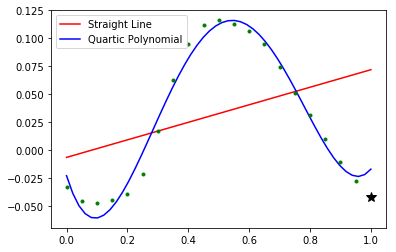

0.0719272011205
0.0719272011205
-0.0168234251355
-0.0168234251357
(-0.0, 0.0) 1.35581519775e-05
(-0.0, 0.0) 1.33999180498e-05
(-0.0, 0.0)


In [1]:
%matplotlib inline
import numpy as np
import scipy.io as io
import matplotlib
import matplotlib.pyplot as plt

## 1. Getting Started
#Data Reshape & Shuffle
amp_data = io.loadmat('/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat')
arr_len = amp_data['amp_data'].shape[0]
split = int(int(arr_len/21)*21)
amp_data = amp_data['amp_data'][0:split,:].reshape(-1, 21)
np.random.seed(0)
np.random.shuffle(amp_data)

#Make train, validation, test sets
train_flag = int(amp_data.shape[0]*0.7)
valid_flag = train_flag+1
test_flag = valid_flag + int((amp_data.shape[0]-valid_flag)/2)
X_shuf_train = amp_data[0:train_flag,0:20]
y_shuf_train = amp_data[0:train_flag,20]
X_shuf_val = amp_data[valid_flag:test_flag,0:20]
y_shuf_val = amp_data[valid_flag:test_flag,20]
X_shuf_test = amp_data[test_flag:,0:20]
y_shuf_test = amp_data[test_flag:,20]

## 2. Curve fitting on a snippet of audio
x = np.array([list(float(i)/20.0 for i in range(20))])
y = X_shuf_train[0,:]
target = y_shuf_train[0]

#straight line
x_str = np.concatenate([np.ones((1,20)), x]).T
s_fit = np.linalg.lstsq(x_str, y)[0]
x_ = np.linspace(0,1)
str_eq = eval('x_*s_fit[1]+s_fit[0]')

#quartic polynomial
x_qua = np.concatenate([np.ones((1,20)), x, \
                        np.power(x,2), np.power(x,3), np.power(x,4)]).T
q_fit = np.linalg.lstsq(x_qua, y)[0]
qua_eq = eval('q_fit[0]+q_fit[1]*x_+q_fit[2]*x_**2+q_fit[3]*x_**3+q_fit[4]*x_**4')

plt.plot(x_, str_eq,'r')
plt.plot(x_, qua_eq, 'b')
plt.plot(x, y.reshape(1,20), 'g.')
plt.plot(1.0, target, 'k*', markersize=10)
plt.legend(["Straight Line","Quartic Polynomial"])
plt.show()

## 3. Choosing a polynomial predictor based on performance

def Phi(C, K):
    phi_matrix = []
    for i in [float(t)/20.0 for t in range(20-C,20)]:
        feature = []
        for j in range(K):
            feature.append(i**j)
        phi_matrix.append(feature)
    return np.array(phi_matrix)

def make_vv(C, K):
    features = Phi(C,K)
    phi_1 = np.ones(K)
    a = np.linalg.inv(np.dot(features.T, features))
    return  np.dot(np.dot(features, a), phi_1)
#predictions
vector_K1 = make_vv(20,2)
print(1.0*s_fit[1]+s_fit[0])
print(vector_K1.dot(y.T))

vector_K4 = make_vv(20,5)
x_=1.0
print(q_fit[0]+q_fit[1]*x_+q_fit[2]*x_**2+q_fit[3]*x_**3+q_fit[4]*x_**4)
print(vector_K4.dot(y.T))


def mean_squared_error(Y, X):
    return np.sum([np.power(Y-X,2)])/Y.shape[0]

#evaluate predictors

res_train = []
res_val = []
res_test = []

for C in range(2,21):
    a = []
    b=[]
    c=[]
    for K in range(2,10):
        vector = make_vv(C,K)
        a.append(mean_squared_error(y_shuf_train, vector.dot(X_shuf_train[:,20-C:20].T)))
        b.append(mean_squared_error(y_shuf_val, vector.dot(X_shuf_val[:,20-C:20].T)))
        c.append(mean_squared_error(y_shuf_test, vector.dot(X_shuf_test[:,20-C:20].T)))
    res_train.append(a)
    res_val.append(b)
    res_test.append(c)

res_train = np.array(res_train)
arg_min  = res_train.argmin()
ravel = res_train.ravel()[res_train.argmin()]
div_m = divmod(arg_min, ravel)
print(divmod(arg_min, ravel), res_train[int(div_m[0]),int(div_m[1])])

res_val = np.array(res_val)
arg_min  = res_val.argmin()
ravel = res_val.ravel()[arg_min]
div_m = divmod(arg_min, ravel)
print(divmod(arg_min, ravel), res_val[int(div_m[0]),int(div_m[1])])

res_test = np.array(res_test)
arg_min  = res_test.argmin()
ravel = res_test.ravel()[arg_min]
print(divmod(arg_min, ravel))
    


## 4. Fitting linear predictors across many snippets
